# Transformation Comparison: Dropout vs DropConnect vs Ensemble vs Bayesian vs Evidential (PyTorch)

*Date:* 2026-01-29

**Audience:** Users who already looked at the individual transformation notebooks  
**Framework:** PyTorch  
**Goal:** Compare predictive uncertainty behavior on the same 1D regression setup.

## What this notebook does
- trains the same base MLP under different `probly.transformation` methods
- compares RMSE (against noise-free ground truth)
- compares NLL in-domain vs OOD
- plots predictive mean ± 2 std
- for evidential: decomposes aleatoric vs epistemic

## What this notebook does NOT do
- does not claim best hyperparameters or best performance
- is not a benchmark, just a reproducible sanity-check style comparison


In [2]:
import math

import matplotlib.pyplot as plt
import numpy as np
import torch

from probly.transformation.bayesian import bayesian
from probly.transformation.dropconnect import dropconnect
from probly.transformation.dropout import dropout
from probly.transformation.ensemble import ensemble
from probly.transformation.evidential.regression import evidential_regression

In [3]:
torch.manual_seed(0)
np.random.seed(0)

device = torch.device("cpu")
device

device(type='cpu')

In [4]:
CFG = {
    "seed": 0,
    "epochs": 500,
    "mc_samples": 75,
    "ensemble_members": 3,
    "ensemble_epochs": 500,
    "evidential_epochs": 800,
    "verbose_every": 0,
}

In [5]:
from collections.abc import Callable

from torch import nn


def make_torch_regression_model_1d() -> nn.Module:
    """Small 1D regression MLP used as the base model in this tutorial."""
    return nn.Sequential(
        nn.Linear(2, 2),
        nn.ReLU(),
        nn.Linear(2, 1),
    )


def fallback_regression_model_1d() -> nn.Module:
    """Fallback model when fixtures are unavailable.

    Must match make_torch_regression_model_1d for consistent results.
    """
    return make_torch_regression_model_1d()


MAKE_BASE: Callable[[], nn.Module] = make_torch_regression_model_1d
print("Using base model factory: make_torch_regression_model_1d")

Using base model factory: make_torch_regression_model_1d


In [6]:
def make_dataset(
    n_train: int = 256,
    n_test: int = 400,
    train_range: float = 4.0,
    test_range: float = 6.0,
    noise_var: float = 3.0,
) -> tuple[
    tuple[torch.Tensor, torch.Tensor, torch.Tensor],
    tuple[torch.Tensor, torch.Tensor, torch.Tensor],
    float,
]:
    """Generate a simple 1D regression dataset with 2D features [x, x^2]."""
    noise_std = math.sqrt(noise_var)

    x_train = torch.rand(n_train, 1) * 2 * train_range - train_range
    x_test = torch.linspace(-test_range, test_range, n_test).unsqueeze(1)

    x_train_2d = torch.cat([x_train, x_train**2], dim=1)
    x_test_2d = torch.cat([x_test, x_test**2], dim=1)

    y_train = x_train**3 + noise_std * torch.randn_like(x_train)
    y_test_true = x_test**3  # noise-free "true function" for plotting

    return (x_train_2d, y_train, x_train), (x_test_2d, y_test_true, x_test), noise_std


(train_x, train_y, train_x1), (test_x, test_y_true, test_x1), noise_std = make_dataset()
train_x, train_y, test_x, test_y_true = [t.to(device) for t in [train_x, train_y, test_x, test_y_true]]

train_x1 = train_x1.to(device)
test_x1 = test_x1.to(device)

test_y = test_y_true + noise_std * torch.randn_like(test_y_true)

x_min, x_max = train_x1.min(), train_x1.max()
in_mask = (test_x1 >= x_min) & (test_x1 <= x_max)
ood_mask = ~in_mask

known_noise_std = noise_std

noise_std

1.7320508075688772

## Dataset design

We use a simple 1D regression with **known noise**:

- True function: **y = x³**
- Training inputs: x ∈ [-4, 4]
- Test inputs: x ∈ [-6, 6] (includes extrapolation regions)
- Observation noise: ε ~ Normal(0, σ²)

Why this setup:
- Inside [-4,4], models should fit well and uncertainty should be moderate.
- Outside [-4,4], epistemic uncertainty should usually increase (less evidence).
- Because we know σ, we can separate:
  - **epistemic** (model uncertainty estimated via sampling/disagreement)
  - **aleatoric** (data noise, fixed by construction)


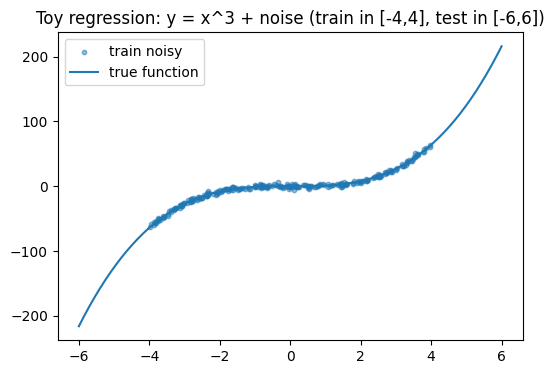

In [7]:
plt.figure(figsize=(6, 4))
plt.scatter(train_x1.cpu().numpy(), train_y.cpu().numpy(), s=10, alpha=0.5, label="train noisy")
plt.plot(test_x1.cpu().numpy(), test_y_true.cpu().numpy(), label="true function")
plt.title("Toy regression: y = x^3 + noise (train in [-4,4], test in [-6,6])")
plt.legend()
plt.show()

### Uncertainty & evaluation setup (important)

In this notebook, epistemic uncertainty for dropout / dropconnect / ensemble / Bayesian methods is estimated via repeated stochastic forward passes (MC samples). Observation noise is assumed to be **known and homoskedastic Gaussian noise** from the data generation process, denoted as `known_noise_std`.

Therefore, we form the total predictive uncertainty as:

`total_std = sqrt(epistemic_std**2 + known_noise_std**2)`

For evaluation, **RMSE** is computed against the noise-free target `test_y_true` (function approximation quality), while **NLL** is computed against the noisy observations `test_y` (distributional calibration). We additionally report NLL separately for **in-distribution** (within the training x-range) and **OOD** (outside the training x-range).


In [8]:
from torch import Tensor


@torch.no_grad()
def mc_predict(
    model: nn.Module,
    x: Tensor,
    num_samples: int = 75,
    force_train_mode: bool = False,
) -> tuple[Tensor, Tensor]:
    was_training = model.training
    model.train(mode=force_train_mode)

    preds: list[Tensor] = []
    for _ in range(num_samples):
        preds.append(model(x))

    stacked = torch.stack(preds, dim=0)
    mean = stacked.mean(dim=0)
    std = stacked.std(dim=0, unbiased=False)

    model.train(mode=was_training)
    return mean, std


def train_mse(
    model: torch.nn.Module,
    x: torch.Tensor,
    y: torch.Tensor,
    epochs: int = 500,
    lr: float = 1e-2,
    weight_decay: float = 0.0,
    verbose_every: int = 300,
) -> torch.nn.Module:
    """Train a model with MSE loss on (x, y)."""
    model.to(device)
    model.train()

    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = torch.nn.MSELoss()

    for ep in range(1, epochs + 1):
        opt.zero_grad()
        pred = model(x)
        loss = loss_fn(pred, y)
        loss.backward()
        opt.step()

        if verbose_every and ep % verbose_every == 0:
            print(f"epoch {ep:4d} | mse {loss.item():.4f}")

    return model


def gaussian_nll(
    y: torch.Tensor,
    mean: torch.Tensor,
    std: torch.Tensor,
) -> torch.Tensor:
    """Pointwise Gaussian negative log-likelihood."""
    var = std**2 + 1e-8
    return 0.5 * torch.log(2 * math.pi * var) + 0.5 * (y - mean) ** 2 / var


def mean_nll(
    y: torch.Tensor,
    mean: torch.Tensor,
    std: torch.Tensor,
    mask: torch.Tensor | None = None,
) -> float:
    nll = gaussian_nll(y, mean, std)
    if mask is not None:
        nll = nll[mask]
    return nll.mean().item()


@torch.no_grad()
def rmse(y: torch.Tensor, mean: torch.Tensor) -> float:
    """Root mean squared error."""
    return torch.sqrt(torch.mean((y - mean) ** 2)).item()

## Predictive uncertainty via sampling

Some transformations are stochastic at inference:
- **dropout / dropconnect**: randomness comes from masks
- **bayesian**: randomness comes from weight sampling (implementation-dependent)
- **ensemble**: randomness comes from multiple trained members (no repeated sampling needed)

For these methods we estimate:
- Predictive mean: average over samples/models
- Epistemic std: standard deviation over samples/models

Because our base models output only a single scalar (no explicit noise head),
we form a **total** predictive std using:

total_std = sqrt(epistemic_std² + noise_std²)

This gives a reasonable predictive distribution for NLL evaluation.


In [9]:
dist = torch.distributions


def evidential_studentt_params(
    out_dict: dict[str, torch.Tensor],
) -> tuple[
    torch.Tensor,
    torch.Tensor,
    torch.Tensor,
    torch.Tensor,
    torch.Tensor,
    torch.Tensor,
    torch.Tensor,
]:
    gamma = out_dict["gamma"]
    nu = out_dict["nu"]
    alpha = out_dict["alpha"]
    beta = out_dict["beta"]

    df = 2.0 * alpha
    loc = gamma
    var = beta * (1.0 + nu) / (nu * alpha)
    scale = torch.sqrt(var + 1e-8)
    return gamma, nu, alpha, beta, df, loc, scale


def evidential_loss(
    out_dict: dict[str, torch.Tensor],
    y: torch.Tensor,
    lam: float = 0.01,
) -> tuple[torch.Tensor, float, float]:
    gamma, nu, alpha, beta, df, loc, scale = evidential_studentt_params(out_dict)
    tdist = dist.StudentT(df=df, loc=loc, scale=scale)

    nll = -tdist.log_prob(y).mean()
    evidence = 2.0 * nu + alpha
    reg = (torch.abs(y - gamma) * evidence).mean()

    return nll + lam * reg, nll.item(), reg.item()


@torch.no_grad()
def evidential_decompose(
    out_dict: dict[str, torch.Tensor],
) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    gamma = out_dict["gamma"]
    nu = out_dict["nu"]
    alpha = out_dict["alpha"]
    beta = out_dict["beta"]

    ale_var = beta / (alpha - 1.0 + 1e-8)
    epi_var = beta / (nu * (alpha - 1.0 + 1e-8))

    ale_std = torch.sqrt(ale_var + 1e-8)
    epi_std = torch.sqrt(epi_var + 1e-8)
    total_std = torch.sqrt(ale_var + epi_var + 1e-8)

    return gamma, ale_std, epi_std, total_std

## Train + Evaluate: Dropout
MC sampling at inference (keep train mode during prediction).


## Dropout (MC Dropout)

Training is standard MSE.
At evaluation we keep the model in `train()` mode so dropout stays active, then run
many forward passes. Variation across predictions approximates epistemic uncertainty.


In [10]:
base = MAKE_BASE().to(device)
m_dropout = dropout(base, p=0.1).to(device)

m_dropout = train_mse(m_dropout, train_x, train_y, epochs=CFG["epochs"], lr=1e-2, verbose_every=CFG["verbose_every"])

# MC sampling (force train mode so dropout is active)
mean_do, std_do = mc_predict(m_dropout, test_x, num_samples=CFG["mc_samples"], force_train_mode=True)

# Total std: epistemic from MC + known aleatoric (noise_std)
total_std_do = torch.sqrt(std_do**2 + noise_std**2)

nll_do_in = mean_nll(test_y, mean_do, total_std_do, in_mask)
nll_do_ood = mean_nll(test_y, mean_do, total_std_do, ood_mask)

rmse_do = rmse(test_y_true, mean_do)

print("Dropout | RMSE:", rmse_do, "| NLL_in:", nll_do_in, "| NLL_ood:", nll_do_ood)

Dropout | RMSE: 66.88179016113281 | NLL_in: 40.215293884277344 | NLL_ood: 322.47161865234375


## Train + Evaluate: DropConnect
MC sampling at inference (keep train mode during prediction).


## DropConnect

Same idea as dropout, but the randomness affects connections/weights rather than activations
(depending on implementation). We again use multiple forward passes to estimate epistemic uncertainty.


In [11]:
base = MAKE_BASE().to(device)
m_dc = dropconnect(base, p=0.1).to(device)

m_dc = train_mse(m_dc, train_x, train_y, epochs=CFG["epochs"], lr=1e-2, verbose_every=CFG["verbose_every"])

mean_dc, std_dc = mc_predict(m_dc, test_x, num_samples=CFG["mc_samples"], force_train_mode=True)
total_std_dc = torch.sqrt(std_dc**2 + noise_std**2)

nll_dc_in = mean_nll(test_y, mean_dc, total_std_dc, in_mask)
nll_dc_ood = mean_nll(test_y, mean_dc, total_std_dc, ood_mask)

rmse_dc = rmse(test_y_true, mean_dc)

print("DropConnect | RMSE:", rmse_dc, "| NLL_in:", nll_dc_in, "| NLL_ood:", nll_dc_ood)

DropConnect | RMSE: 66.45568084716797 | NLL_in: 37.09754180908203 | NLL_ood: 437.0319519042969


## Train + Evaluate: Ensemble
No MC sampling: variance comes from member disagreement.


## Ensemble

`probly.transformation.ensemble(...)` returns a `torch.nn.ModuleList`, i.e. multiple independent members.

Key consequence:
- You cannot do `members(X)` because `ModuleList` has no `forward`.
- You must run each member separately, then aggregate.

Uncertainty comes from **member disagreement**:
- mean over members = predictive mean
- std over members = epistemic uncertainty estimate


In [12]:
from collections.abc import Sequence

base = MAKE_BASE().to(device)
members = ensemble(base, num_members=CFG["ensemble_members"], reset_params=True)

for mm in members:
    mm.to(device)

opt = torch.optim.Adam([p for mm in members for p in mm.parameters()], lr=1e-2)
loss_fn = torch.nn.MSELoss()

for ep in range(1, CFG["ensemble_epochs"] + 1):
    opt.zero_grad()

    member_losses = [loss_fn(mm(train_x), train_y) for mm in members]
    loss = torch.stack(member_losses).mean()

    loss.backward()
    opt.step()

    if CFG["verbose_every"] and ep % CFG["verbose_every"] == 0:
        print(f"epoch {ep:4d} | mse {loss.item():.4f}")


@torch.no_grad()
def ensemble_predict(
    members: Sequence[torch.nn.Module],
    x: torch.Tensor,
) -> tuple[torch.Tensor, torch.Tensor]:
    """Predictive mean and std across ensemble members."""
    preds: list[torch.Tensor] = []
    for mm in members:
        mm.eval()
        preds.append(mm(x))
    stacked = torch.stack(preds, dim=0)  # [M, N, 1]
    return stacked.mean(dim=0), stacked.std(dim=0, unbiased=False)


mean_ens, std_ens = ensemble_predict(members, test_x)
total_std_ens = torch.sqrt(std_ens**2 + noise_std**2)

nll_ens_in = mean_nll(test_y, mean_ens, total_std_ens, in_mask)
nll_ens_ood = mean_nll(test_y, mean_ens, total_std_ens, ood_mask)

rmse_ens = rmse(test_y_true, mean_ens)

print("Ensemble | RMSE:", rmse_ens, "| NLL_in:", nll_ens_in, "| NLL_ood:", nll_ens_ood)

Ensemble | RMSE: 54.49751281738281 | NLL_in: 2.9756195545196533 | NLL_ood: 6.665450572967529


## Train + Evaluate: Bayesian
We treat the transformed model as stochastic and MC-sample it at inference.
(Training is plain MSE here, because this notebook is about using the ProBly transformation API.)


## Bayesian transformation (practical note)

In a “full Bayesian” setup you might train with an ELBO/KL term.
Here we deliberately keep training simple (MSE), because the goal of this notebook is to demonstrate:
- the ProBly API usage
- the stochastic behavior at inference
- uncertainty-aware evaluation

We still use MC sampling at inference to obtain a predictive distribution.


In [13]:
base = MAKE_BASE().to(device)
m_bayes = bayesian(base).to(device)

m_bayes = train_mse(m_bayes, train_x, train_y, epochs=CFG["epochs"], lr=1e-2, verbose_every=CFG["verbose_every"])

# MC sampling: even in eval it may be stochastic, but we'll just sample.
mean_b, std_b = mc_predict(m_bayes, test_x, num_samples=CFG["mc_samples"], force_train_mode=False)
total_std_b = torch.sqrt(std_b**2 + noise_std**2)

nll_b_in = mean_nll(test_y, mean_b, total_std_b, in_mask)
nll_b_ood = mean_nll(test_y, mean_b, total_std_b, ood_mask)

rmse_b = rmse(test_y_true, mean_b)

print("Bayesian | RMSE:", rmse_b, "| NLL_in:", nll_b_in, "| NLL_ood:", nll_b_ood)

Bayesian | RMSE: 65.43173217773438 | NLL_in: 37.11834716796875 | NLL_ood: 1430.4635009765625


In [14]:
with torch.no_grad():
    s = torch.stack([m_bayes(test_x) for _ in range(10)], dim=0).std().mean().item()
print("bayes sample std mean:", s)

bayes sample std mean: 29.752193450927734


## Train + Evaluate: Evidential Regression
Single forward gives distribution parameters + analytic decomposition.


## Evidential Regression

Evidential regression returns a dict of distribution parameters:
- gamma: mean-like location
- nu, alpha, beta: evidence/shape parameters

Unlike sampling-based methods, evidential regression can provide an analytic decomposition:
- **aleatoric uncertainty** ~ beta / (alpha - 1)
- **epistemic uncertainty** ~ beta / (nu * (alpha - 1))

We compute:
- Student-t NLL (faithful to evidential predictive distribution)
- Optional Gaussian-approx NLL (for easier comparison with other methods)


In [15]:
base = MAKE_BASE().to(device)
m_evi = evidential_regression(base).to(device)

m_evi.train()
opt = torch.optim.Adam(m_evi.parameters(), lr=1e-3)

for ep in range(1, CFG["evidential_epochs"] + 1):
    opt.zero_grad()
    out = m_evi(train_x)  # dict: gamma, nu, alpha, beta
    loss, nll_val, reg_val = evidential_loss(out, train_y, lam=0.01)
    loss.backward()
    opt.step()

    if ep % 400 == 0:
        print(f"epoch {ep:4d} | loss {loss.item():.4f} | nll {nll_val:.4f} | reg {reg_val:.4f}")

with torch.no_grad():
    out_test = m_evi(test_x)
    mean_evi, ale_std, epi_std, total_std_evi = evidential_decompose(out_test)

    # StudentT NLL (more faithful for evidential)
    gamma, nu, alpha, beta, df, loc, scale = evidential_studentt_params(out_test)
    tdist = dist.StudentT(df=df, loc=loc, scale=scale)
    nll_point_studentt = -tdist.log_prob(
        test_y,
    )
    # Note: NLL is evaluated on noisy observations (test_y),
    # not the noise-free test_y_true.

    nll_evi_studentt_in = nll_point_studentt[in_mask].mean().item()
    nll_evi_studentt_ood = nll_point_studentt[ood_mask].mean().item()

    # Optional: Gaussian approx NLL (for apples-to-apples)
    nll_evi_gauss_in = mean_nll(test_y, mean_evi, total_std_evi, in_mask)
    nll_evi_gauss_ood = mean_nll(test_y, mean_evi, total_std_evi, ood_mask)

    rmse_evi = rmse(test_y_true, mean_evi)

print(
    "Evidential | RMSE:",
    rmse_evi,
    "| NLL(StudentT)_in:",
    nll_evi_studentt_in,
    "| NLL(StudentT)_ood:",
    nll_evi_studentt_ood,
    "| NLL(Gauss)_in:",
    nll_evi_gauss_in,
    "| NLL(Gauss)_ood:",
    nll_evi_gauss_ood,
)

epoch  400 | loss 5.3736 | nll 5.1058 | reg 26.7803
epoch  800 | loss 4.9962 | nll 4.7552 | reg 24.1011
Evidential | RMSE: 79.96048736572266 | NLL(StudentT)_in: 4.8924336433410645 | NLL(StudentT)_ood: 11.615111351013184 | NLL(Gauss)_in: 19.519474029541016 | NLL(Gauss)_ood: 612.5783081054688


In [ ]:
import pandas as pd

results = [
    ("dropout", rmse_do, nll_do_in, nll_do_ood),
    ("dropconnect", rmse_dc, nll_dc_in, nll_dc_ood),
    ("ensemble", rmse_ens, nll_ens_in, nll_ens_ood),
    ("bayesian", rmse_b, nll_b_in, nll_b_ood),
    ("evidential(StudentT)", rmse_evi, nll_evi_studentt_in, nll_evi_studentt_ood),
]

df = pd.DataFrame(results, columns=["method", "rmse", "nll_in", "nll_ood"]).sort_values("nll_ood")

for c in ["rmse", "nll_in", "nll_ood"]:
    df[c] = df[c].apply(lambda x: x.item() if hasattr(x, "item") else float(x))

df = df.round({"rmse": 4, "nll_in": 4, "nll_ood": 4})
df

,method,rmse,nll_in,nll_ood
2,ensemble,54.4975,2.9756,6.6655
4,evidential(StudentT),79.9605,4.8924,11.6151
0,dropout,66.8818,40.2153,322.4716
1,dropconnect,66.4557,37.0975,437.0320
3,bayesian,65.4317,37.1183,1430.4635


## Interpreting the metrics

- **RMSE**: accuracy against the true (noise-free) function y = x³.
  Lower is better.

- **NLL**: evaluates the *full predictive distribution*.
  Lower is better. NLL penalizes:
  - wrong means (poor accuracy)
  - overly small predicted uncertainty (overconfidence)

Caveat:
- For dropout/dropconnect/ensemble/bayesian we use a Gaussian approximation and inject known noise_std.
- For evidential we report Student-t NLL, which is more faithful to its predictive distribution.

**Note:** NLL is computed on the **noisy observations** `test_y` (not the noise-free `test_y_true`) and is reported separately for **in-distribution** (within the training x-range) and **OOD** (outside it), so it reflects both calibration and how uncertainty behaves under extrapolation, penalizing both **under-** and **over-confidence**.



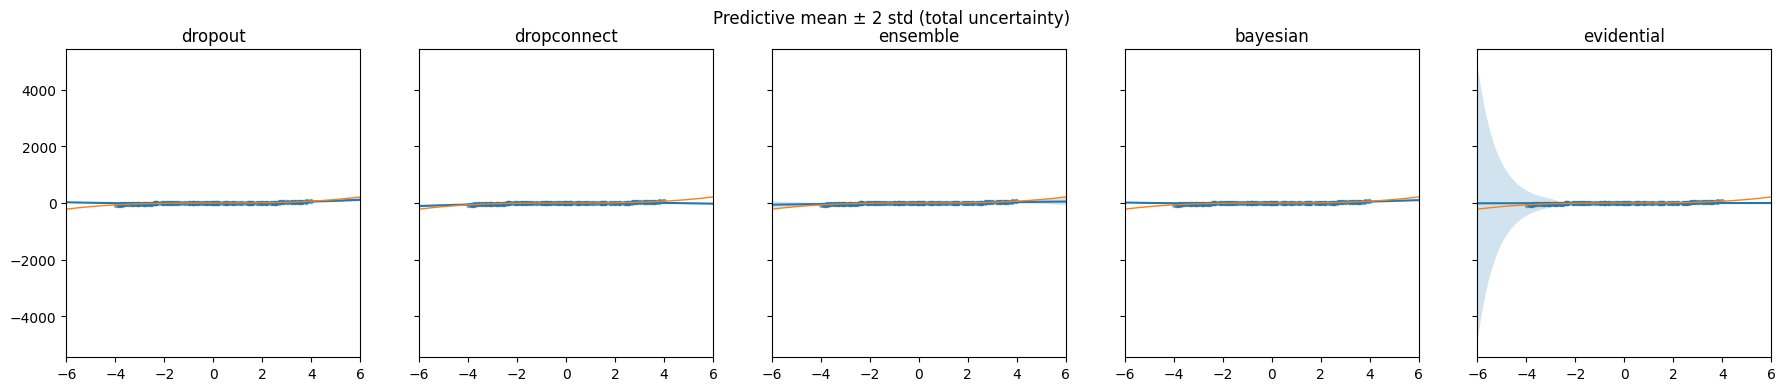

In [22]:
from matplotlib.axes import Axes


def plot_method(
    ax: Axes,
    name: str,
    x: torch.Tensor,
    mean: torch.Tensor,
    std: torch.Tensor,
    color: str | None = None,
) -> None:
    """Plot predictive mean and a +/- 2 std band."""
    x_np = x.detach().cpu().numpy().flatten()
    mean_np = mean.detach().cpu().numpy().flatten()
    std_np = std.detach().cpu().numpy().flatten()

    ax.plot(x_np, mean_np, label=name, color=color)
    ax.fill_between(
        x_np,
        mean_np - 2 * std_np,
        mean_np + 2 * std_np,
        alpha=0.2,
        color=color,
    )


fig, axes = plt.subplots(1, 5, figsize=(22, 4), sharey=True)

# dropout
plot_method(axes[0], "dropout", test_x1, mean_do, total_std_do)
axes[0].scatter(train_x1.cpu().numpy(), train_y.cpu().numpy(), s=8, alpha=0.35)
axes[0].plot(test_x1.cpu().numpy(), test_y_true.cpu().numpy(), linewidth=1)
axes[0].set_title("dropout")

# dropconnect
plot_method(axes[1], "dropconnect", test_x1, mean_dc, total_std_dc)
axes[1].scatter(train_x1.cpu().numpy(), train_y.cpu().numpy(), s=8, alpha=0.35)
axes[1].plot(test_x1.cpu().numpy(), test_y_true.cpu().numpy(), linewidth=1)
axes[1].set_title("dropconnect")

# ensemble
plot_method(axes[2], "ensemble", test_x1, mean_ens, total_std_ens)
axes[2].scatter(train_x1.cpu().numpy(), train_y.cpu().numpy(), s=8, alpha=0.35)
axes[2].plot(test_x1.cpu().numpy(), test_y_true.cpu().numpy(), linewidth=1)
axes[2].set_title("ensemble")

# bayesian
plot_method(axes[3], "bayesian", test_x1, mean_b, total_std_b)
axes[3].scatter(train_x1.cpu().numpy(), train_y.cpu().numpy(), s=8, alpha=0.35)
axes[3].plot(test_x1.cpu().numpy(), test_y_true.cpu().numpy(), linewidth=1)
axes[3].set_title("bayesian")

# evidential
plot_method(axes[4], "evidential", test_x1, mean_evi, total_std_evi)
axes[4].scatter(train_x1.cpu().numpy(), train_y.cpu().numpy(), s=8, alpha=0.35)
axes[4].plot(test_x1.cpu().numpy(), test_y_true.cpu().numpy(), linewidth=1)
axes[4].set_title("evidential")

for ax in axes:
    ax.set_xlim(-6, 6)

plt.suptitle("Predictive mean ± 2 std (total uncertainty)")
plt.show()

## Reading the plots (mean ± 2 std)

- The line is the predictive mean.
- The shaded band is ± 2 standard deviations (a rough uncertainty interval).
- On extrapolation regions (outside [-4,4]), good uncertainty methods often widen the band.
- Inside [-4,4], methods should fit the data and not inflate uncertainty too much.


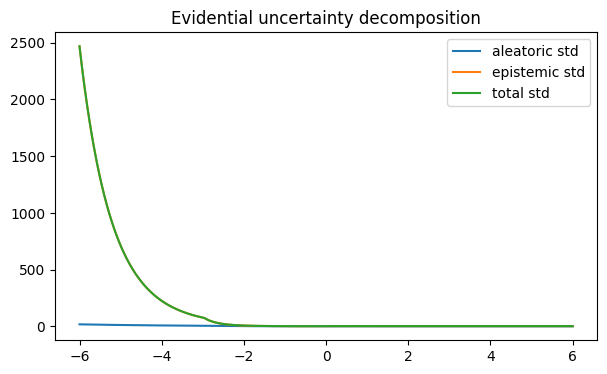

In [19]:
plt.figure(figsize=(7, 4))
plt.plot(test_x1.cpu().numpy(), ale_std.cpu().numpy(), label="aleatoric std")
plt.plot(test_x1.cpu().numpy(), epi_std.cpu().numpy(), label="epistemic std")
plt.plot(test_x1.cpu().numpy(), total_std_evi.cpu().numpy(), label="total std")
plt.title("Evidential uncertainty decomposition")
plt.legend()
plt.show()